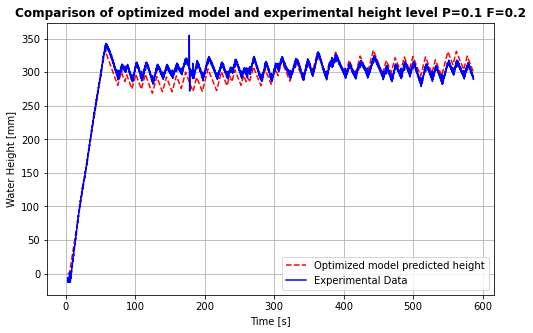

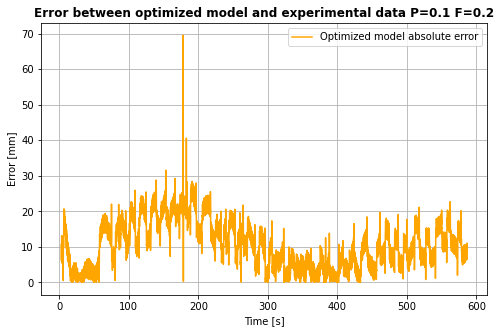

Optimized A3: 6.069727921046056e-05


In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import median_filter
from scipy.optimize import minimize

def ODE(P, F, h0, time, A3, dt=0.1):
    A1 = 0.0154 
    A2 = 4.91e-4  
    k_pump = 1
    g = 9.81  
    k_opening = 1 
    h = h0 
    
    h_vals = np.zeros_like(time)
    
    for i in range(len(time)):
        dh_dt = (k_pump/A1) * P[i] - k_opening * F[i] * (A2 / A1) * np.sqrt(2 * g * h) - (k_opening * F[i] * (A3 / A1) * np.sqrt(2 * g * h))  
        h = max(0, h + dh_dt * dt)  
        h_vals[i] = h

    return time, h_vals

class Experiment():
    def __init__(self, csv_name_, set_values_vs_time=None):
        self.filename = csv_name_
        data = pd.read_csv(self.filename, skiprows=29, usecols=[0, 1, 2, 3], names=['Time', 'Height', 'Pump', 'Valve'])
        data = data.dropna()
        data = data.apply(pd.to_numeric, errors='coerce')
        for column in data.select_dtypes(include=[np.number]).columns:
            data[column + '_filtered'] = median_filter(data[column], size=5)
        self.data = data


file_path = r"/Users/nela_gawrychowska/Desktop/PR2/rec1_002.csv" 
data = Experiment(file_path)

P = data.data['Pump'] * 0.1 
F = data.data['Valve']
h0 = 0  
time = data.data['Time']

def objective(A3):
    time_model, height_model = ODE(P, F, h0, time, A3)
    height_in_mm_model = height_model * 10  #conv. to mm
    error = np.abs(height_in_mm_model - data.data['Height'].to_numpy()) 
    return np.sum(error**2) 

A3_initial = 0.00015

result = minimize(objective, A3_initial, bounds=[(0, 1)]) 

optimal_A3 = result.x[0]

time_model, height_model = ODE(P, F, h0, time, optimal_A3)
height_in_mm_model = height_model * 10  


plt.figure(figsize=(8, 5))
plt.plot(time_model, height_in_mm_model, label="Optimized model predicted height", color='red', linestyle='dashed')
plt.plot(data.data['Time'].to_numpy(), data.data['Height'].to_numpy(), color='b', label="Experimental Data")
plt.xlabel("Time [s]")
plt.ylabel("Water Height [mm]")
plt.title("Comparison of optimized model and experimental height level P=0.1 F=0.2", fontweight='bold')
plt.legend()
plt.grid()
plt.show()

error = np.abs(height_in_mm_model - data.data['Height'].to_numpy())

plt.figure(figsize=(8, 5))
plt.plot(data.data['Time'], error, label="Optimized model absolute error", color='orange')
plt.xlabel("Time [s]")
plt.ylabel("Error [mm]")
plt.title("Error between optimized model and experimental data P=0.1 F=0.2", fontweight='bold')
plt.legend()
plt.grid()
plt.show()

print(f"Optimized A3: {optimal_A3}")
